In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *

# Align IMU

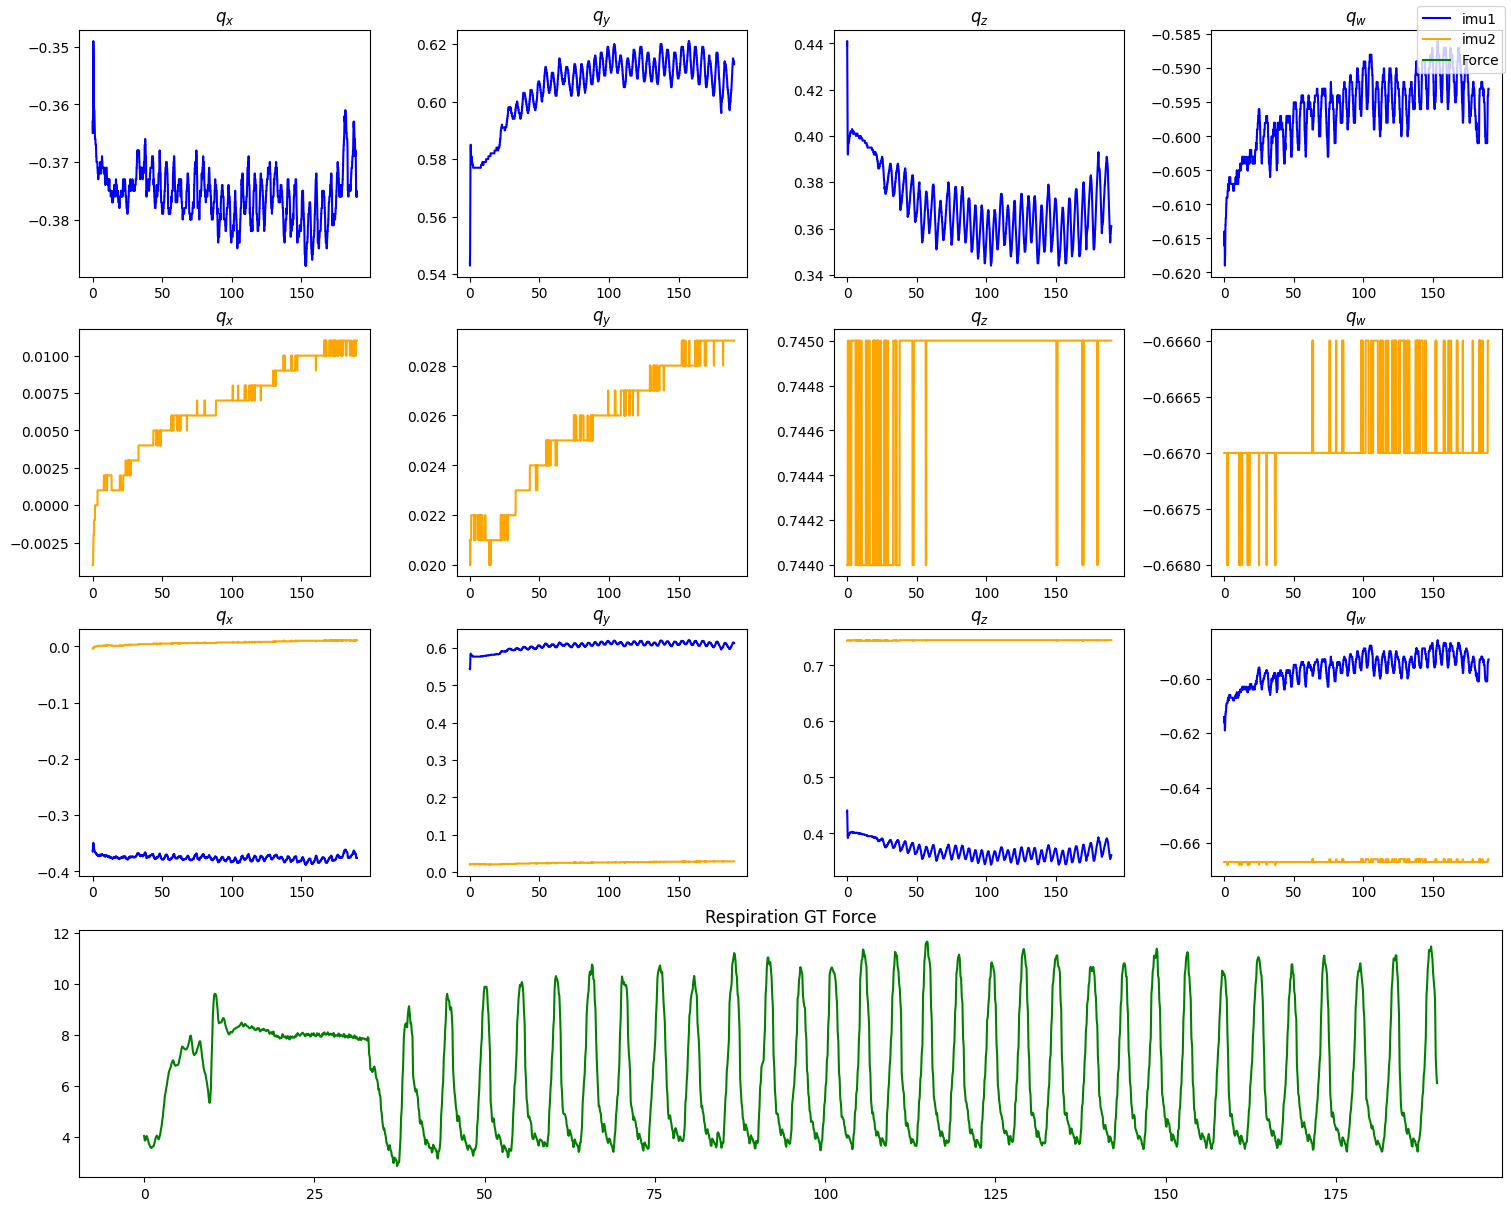

In [3]:
fs = 10
start_pt, end_pt = 0, -30
still_pt = 200 # 500

file_path = "./data/3_6/sit_2.csv" 
# ./data/3_6/sit_2.csv, ./data/3_6/stand_1.csv, ./data/3_6/walk_stand_2.csv, ./data/3_6/wobbleLR_2.csv

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

# shift to 0
# for k, key in enumerate(sensor_names):
#      for i in range(len(cols)):
#           data[key + "_" + cols[i]] = data[key + "_" + cols[i]] - np.mean(data[key + "_" + cols[i]])

data = data.iloc[start_pt:end_pt]

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

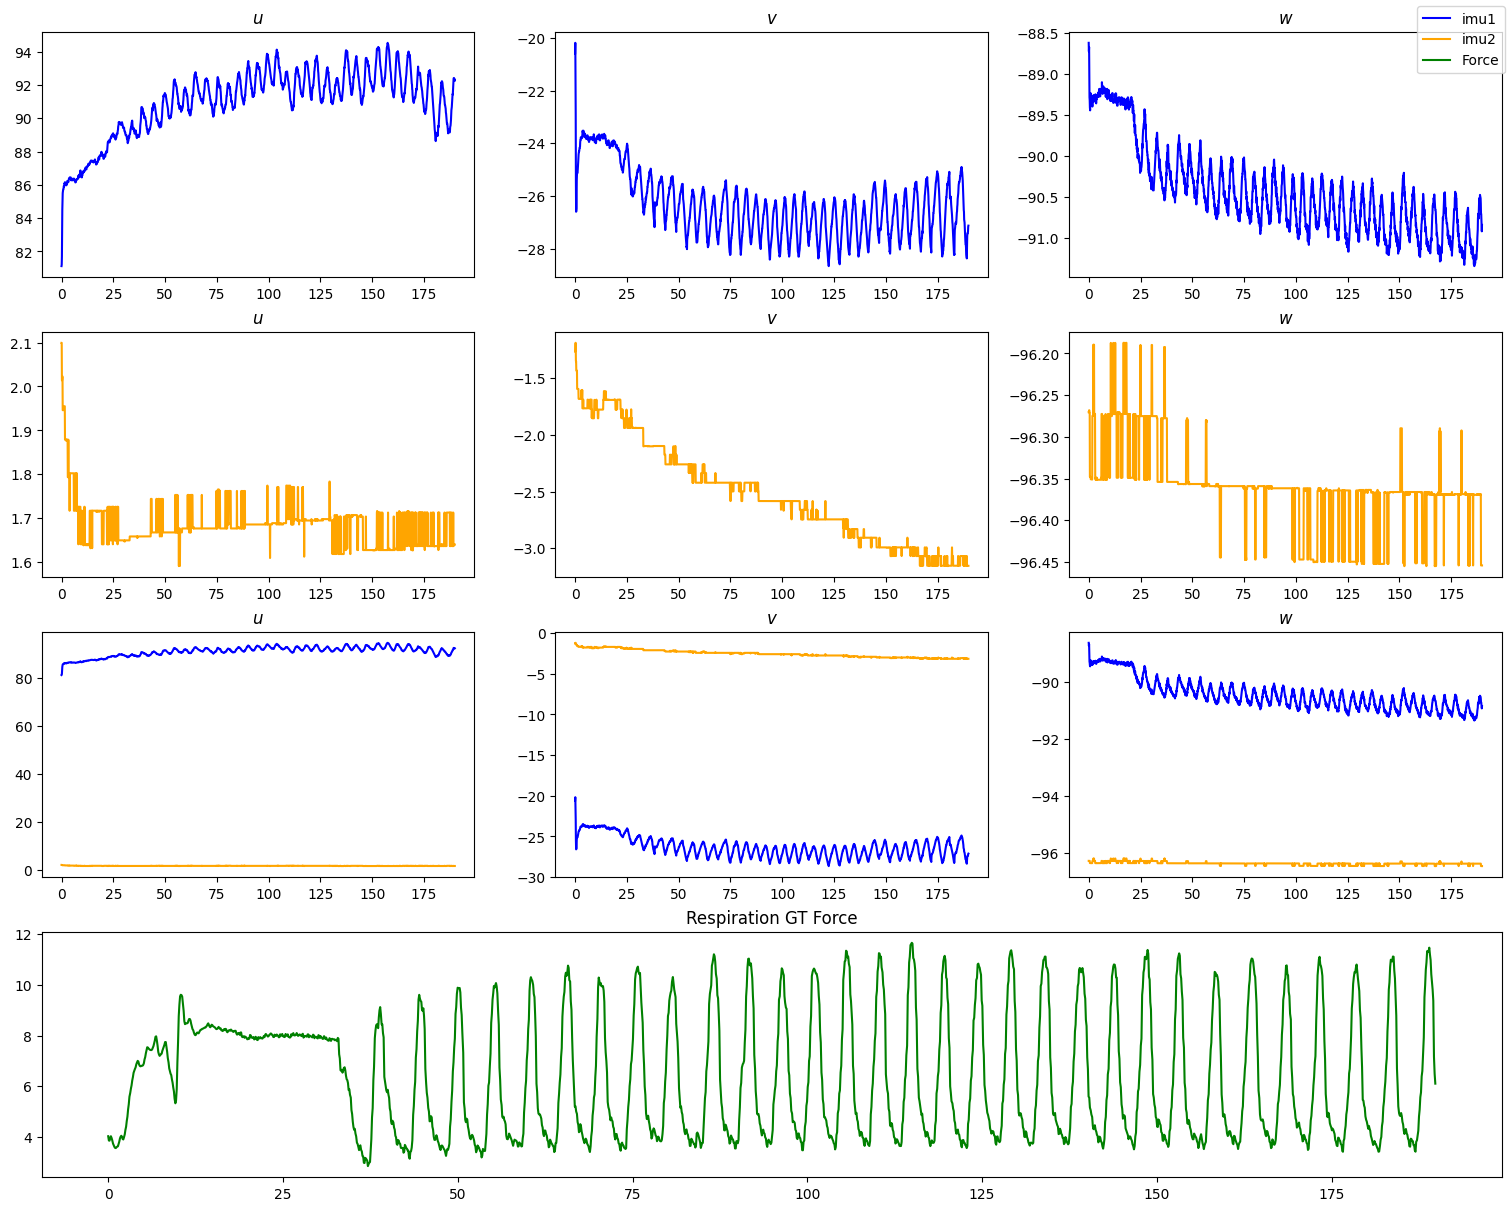

In [4]:
euler_axes = ['u', 'v', 'w']
euler_angles = {}
for imu in sensor_names:
    q = data[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values
    u, v, w = quaternion_to_euler(q)
    euler_angle = [u, v, w]
    # euler_angle = [u - np.mean(u), v - np.mean(v), w - np.mean(w)]
    for i, euler_axis in enumerate(euler_axes):
        euler_angles[imu + "_" + euler_axis] = euler_angle[i]

draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=True)
# draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=False)

In [5]:
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

best_score/total: 196/200


In [6]:
target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

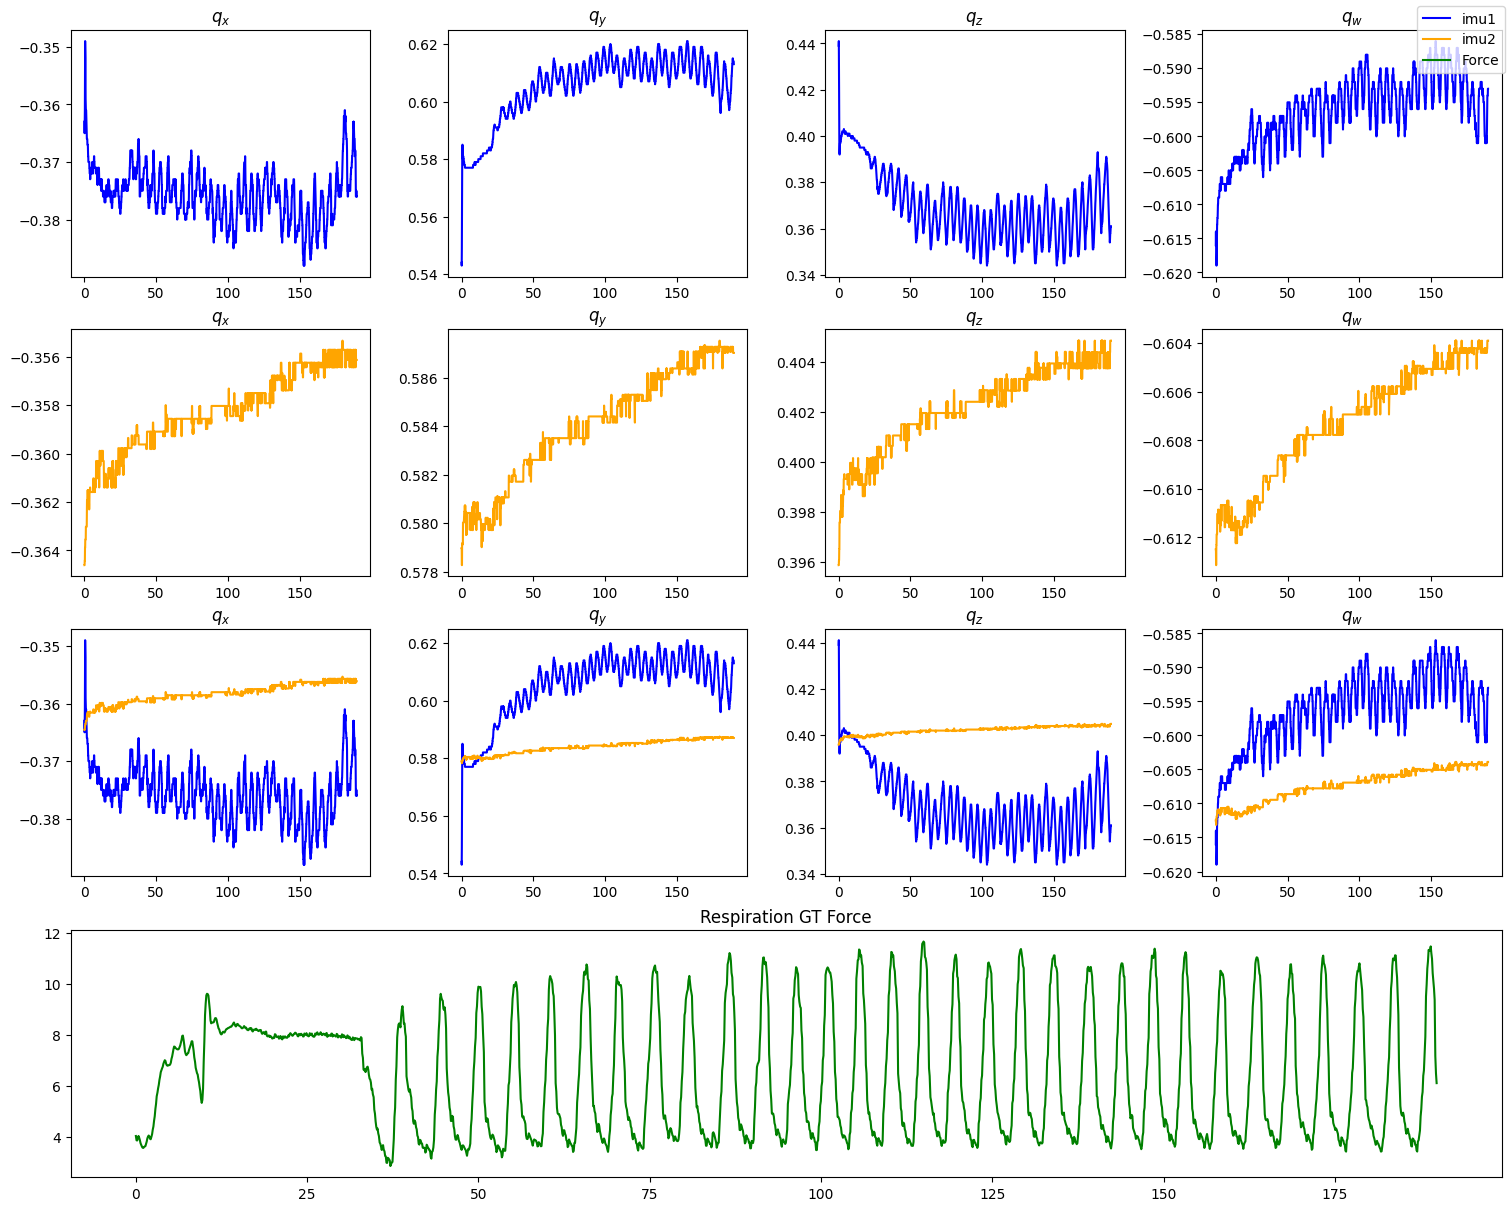

In [7]:
draw_imu_curve(data_aligned, overlap=True, show_gt=True)
# draw_imu_curve(data_aligned, overlap=True, show_gt=False)

In [12]:
# euler_angle: (3, sample_num)
def euler_to_angular_velocity(euler_angle, times):
    angular_velocity = np.zeros_like(euler_angle) 
    for i in range(euler_angle.shape[0]):
        for j in range(euler_angle.shape[1]):
            if j > 0:
                delta_t = (times[j] - times[j-1]).total_seconds()
                angular_velocity[i][j] = (euler_angle[i][j] - euler_angle[i][j-1]) / delta_t
        angular_velocity[i][0] = angular_velocity[i][1]
    
    return angular_velocity

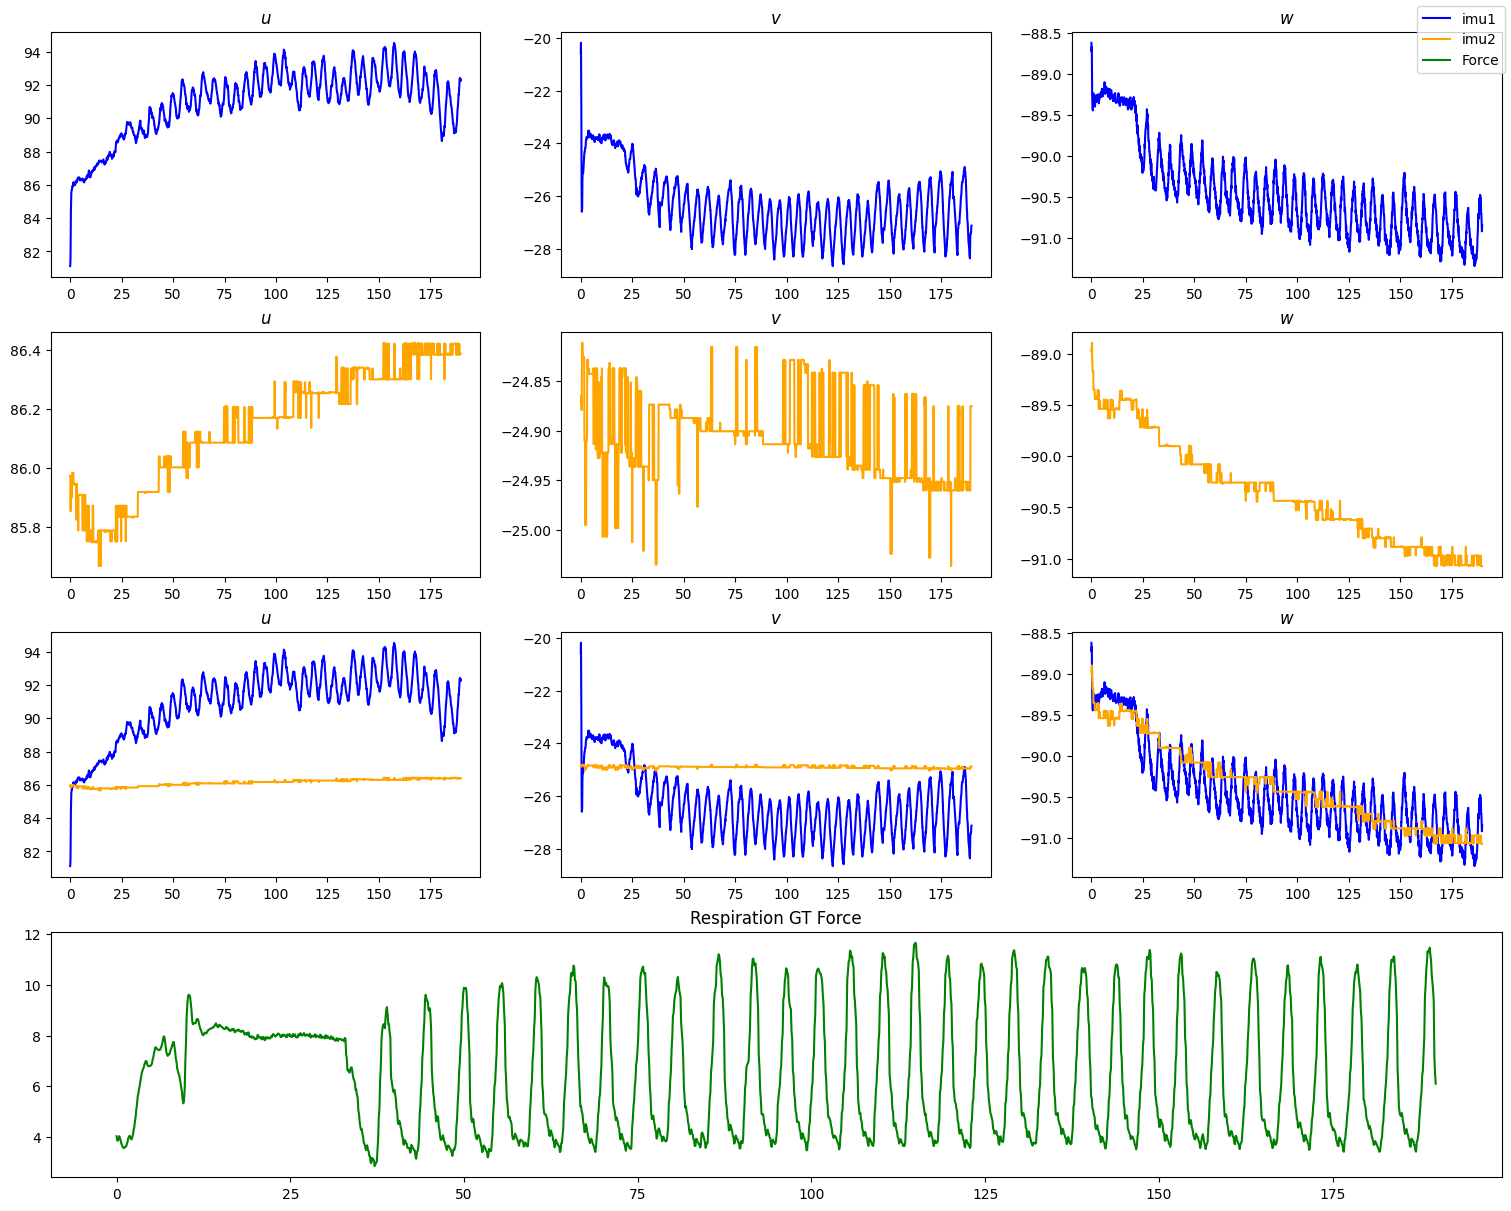

In [13]:
euler_axes = ['u', 'v', 'w']
angular_v_axes = ['\omega_u', '\omega_v', '\omega_w']
euler_angles = {}
for imu in sensor_names:
    q = data_aligned[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values
    u, v, w = quaternion_to_euler(q)
    euler_angle = np.array([u, v, w])
    # euler_angle = [u - np.mean(u), v - np.mean(v), w - np.mean(w)]
    angular_velocity = euler_to_angular_velocity(euler_angle, data_aligned.index)
    for i, euler_axis in enumerate(euler_axes):
        euler_angles[imu + "_" + euler_axis] = euler_angle[i]
        data_aligned[imu + "_" + euler_axis] = euler_angle[i]
        data_aligned[imu + "_" + angular_v_axes[i]] = angular_velocity[i]

draw_imu_curve(data_aligned, cols=['u', 'v', 'w'], overlap=True, show_gt=True)
# draw_imu_curve_euler(data_aligned, euler_angles, overlap=True, show_gt=False)

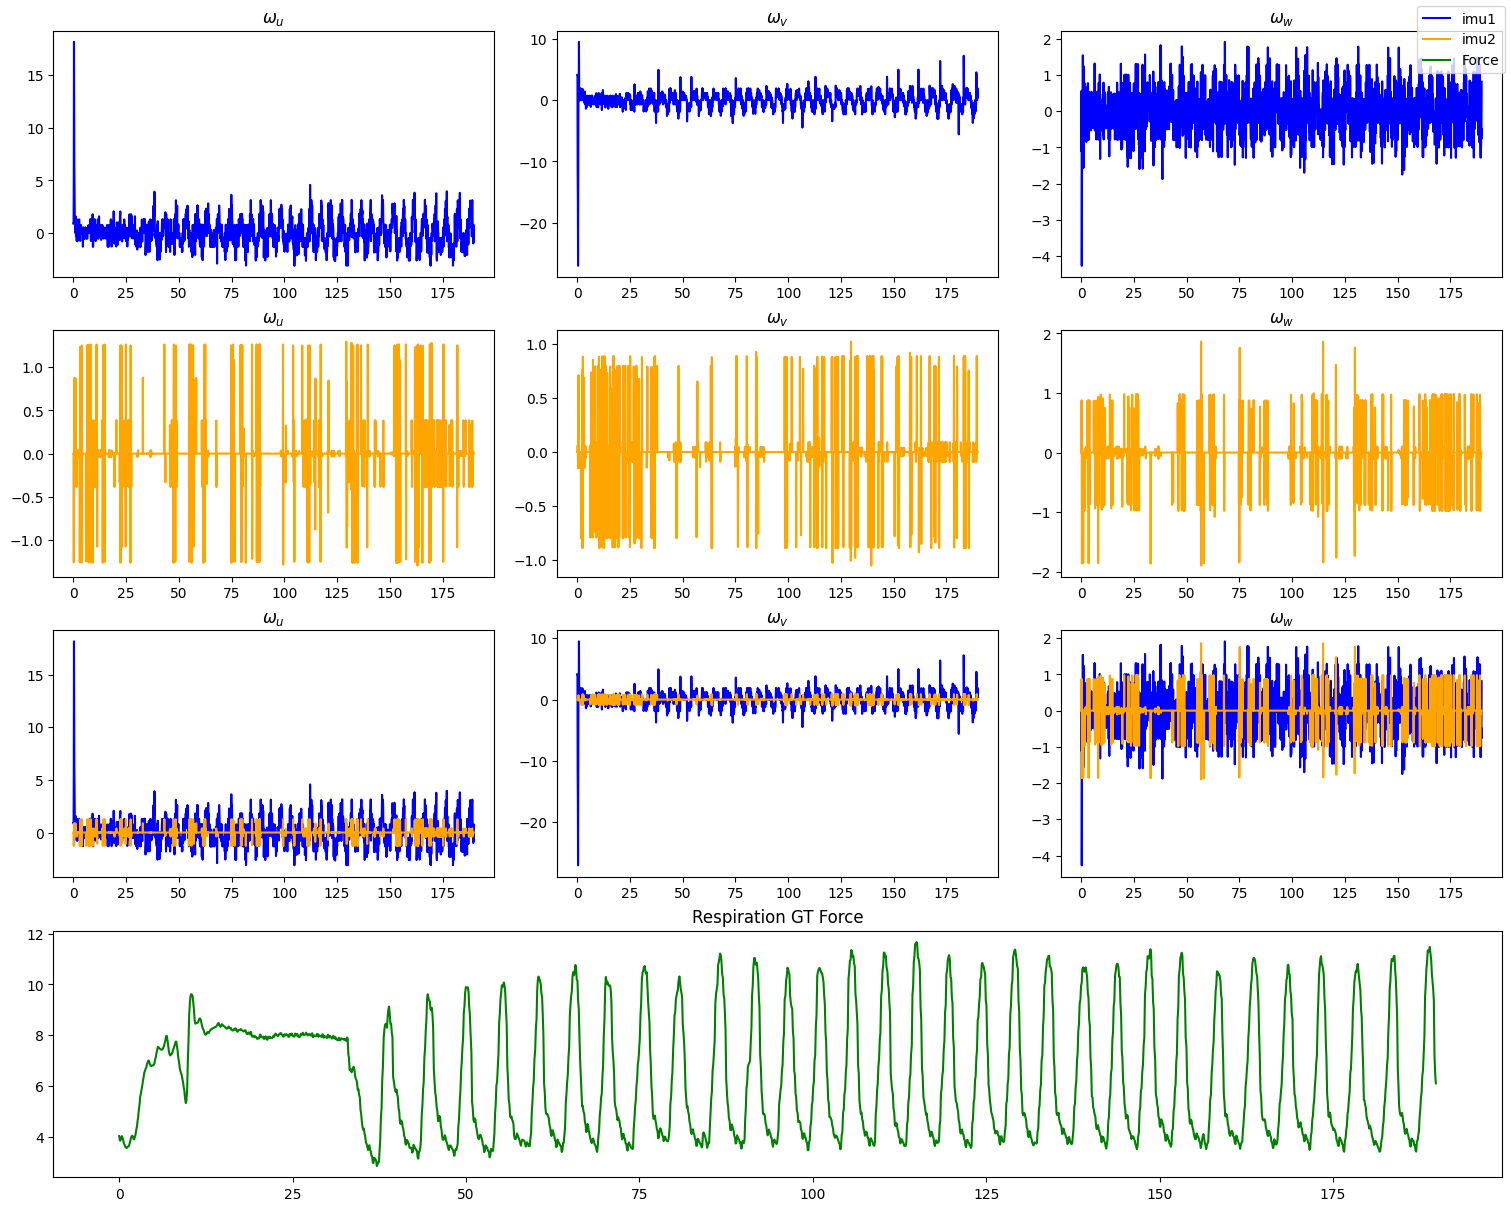

In [15]:
draw_imu_curve(data_aligned, cols=['\omega_u', '\omega_v', '\omega_w'], overlap=True, show_gt=True)

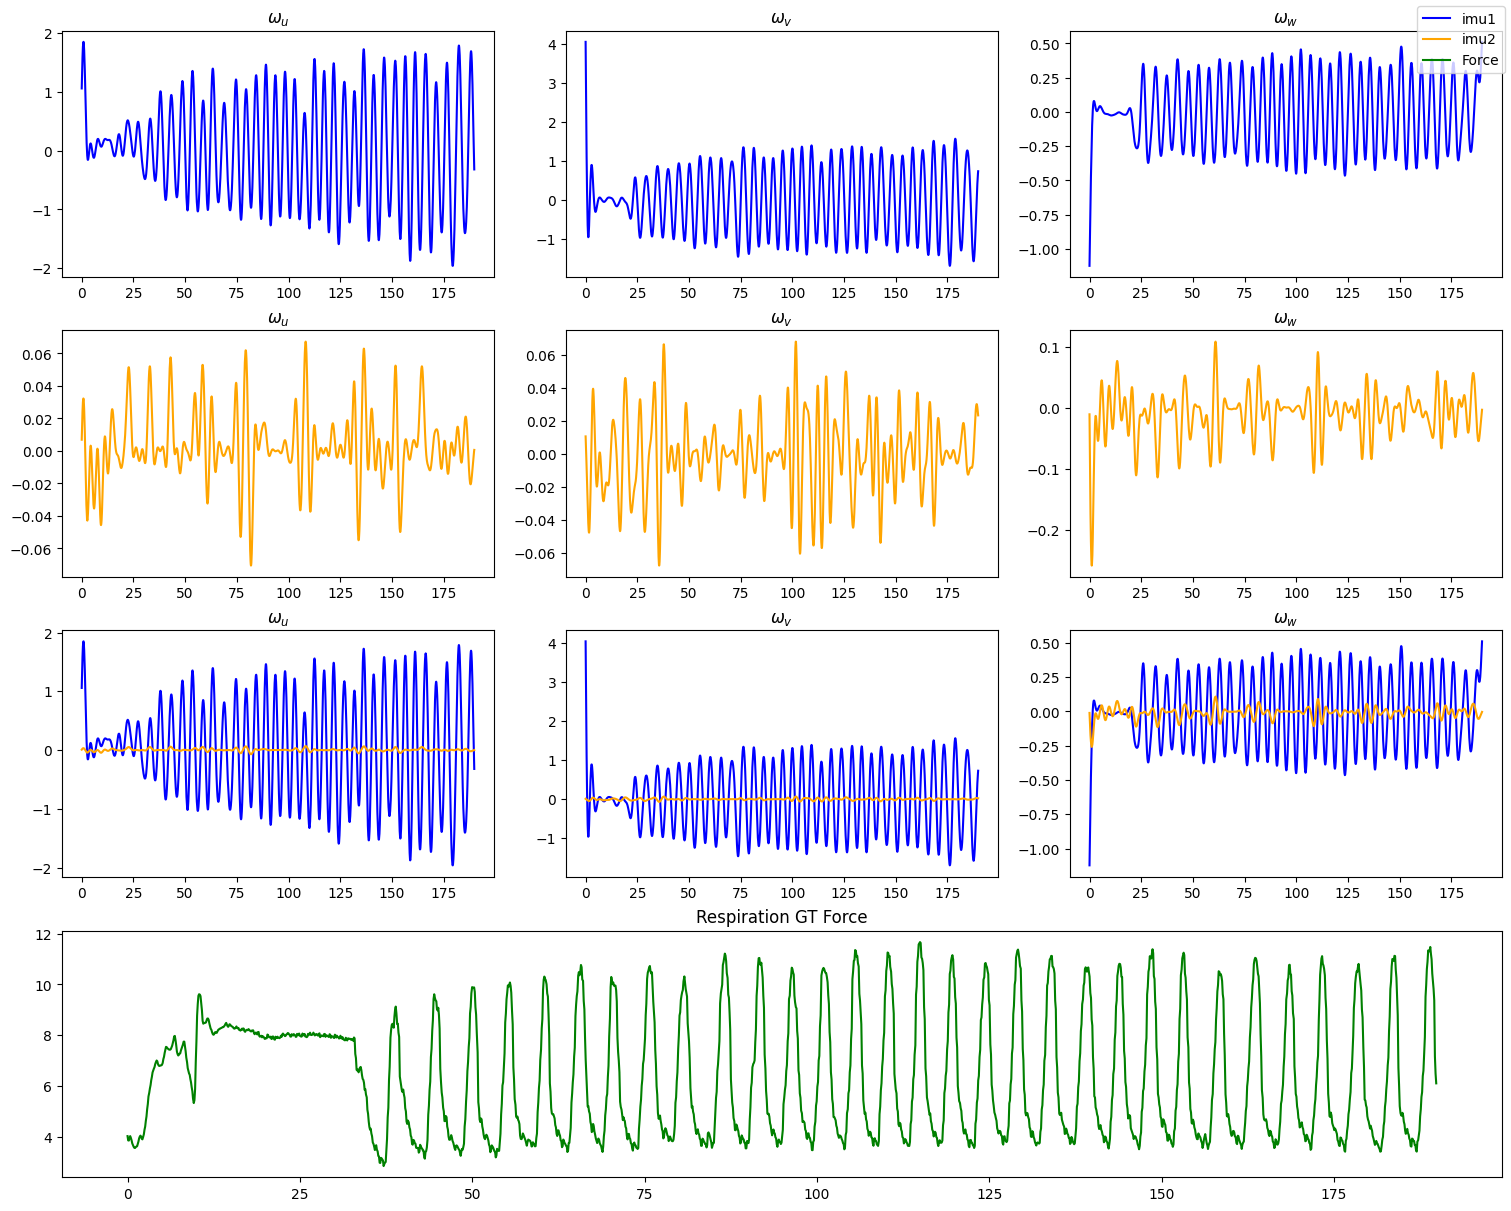

In [17]:
for imu in sensor_names:
    for i, euler_axis in enumerate(euler_axes):
        data_aligned[imu + "_" + angular_v_axes[i]] = butter_filter(data_aligned[imu + "_" + angular_v_axes[i]])

draw_imu_curve(data_aligned, cols=['\omega_u', '\omega_v', '\omega_w'], overlap=True, show_gt=True)

# ANC

In [18]:
data_anc = data_aligned # data used in anc
data_anc = data_anc[still_pt+100:]
# cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion
# cols = ['u', 'v', 'w'] # for euler angle
cols = ['\omega_u', '\omega_v', '\omega_w'] # for angular velocity

data_anc["Force"] = butter_filter(data_anc["Force"])

C:\Users\user\AppData\Local\Temp\ipykernel_21416\1956644770.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_anc["Force"] = butter_filter(data_anc["Force"])


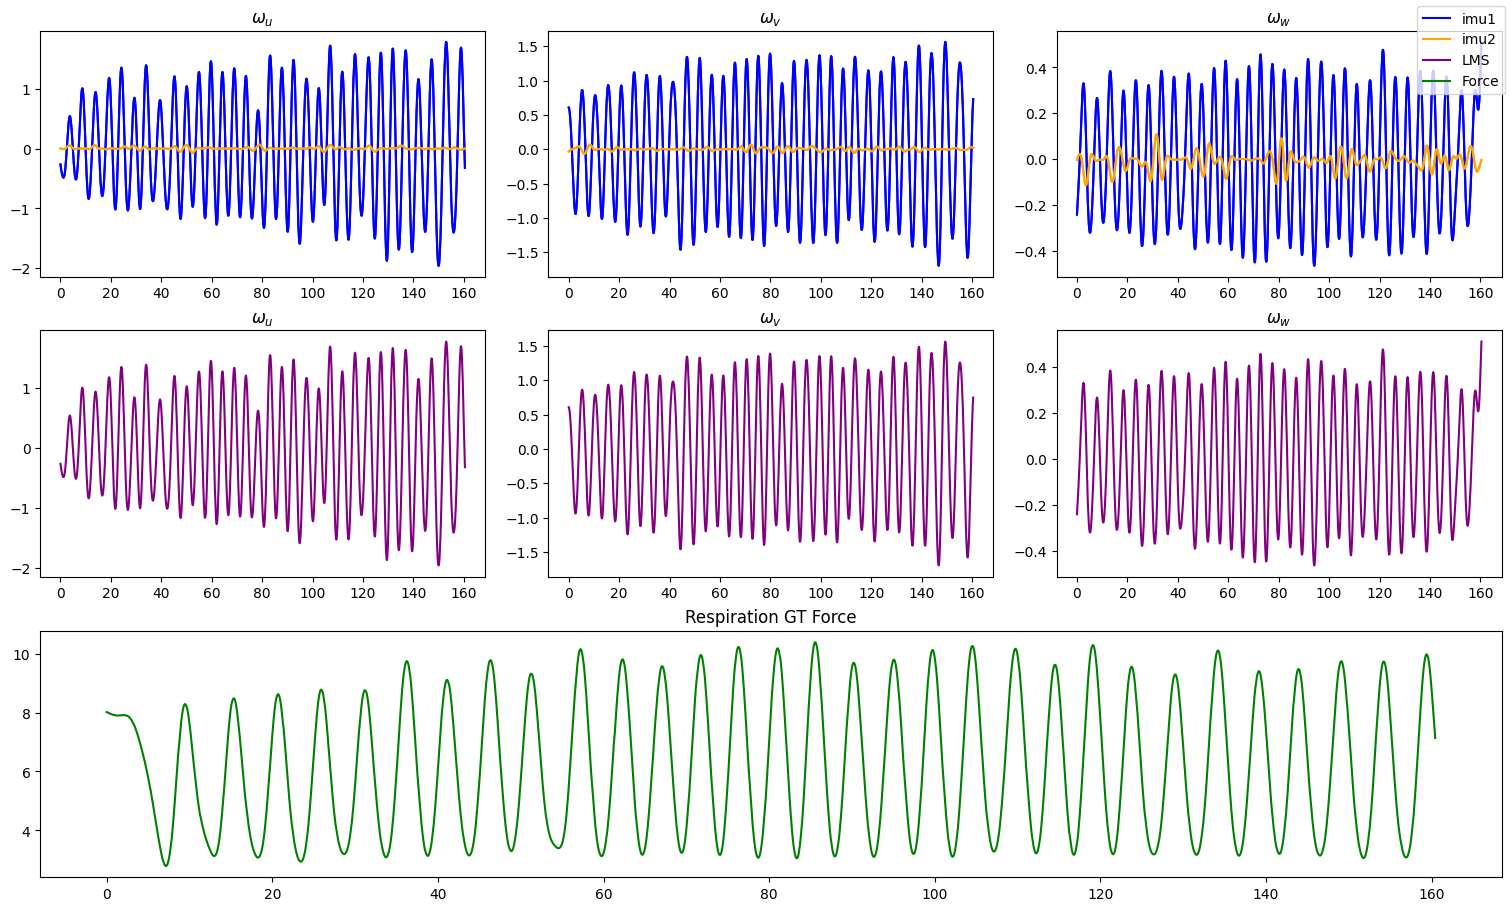

In [19]:
NTAPS = 5 # 10
LEARNING_RATE = 0.01 # 0.001

outputs_dict_LMS = {}
outputs_dict_LMS['method'] = 'LMS'
coefficients_dict_LMS = {}
coefficients_dict_LMS['method'] = 'LMS'
for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_LMS[col] = y
    coefficients_dict_LMS[col] = coefficients_history

# print(outputs_dict_LMS)
draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMS], cols=cols)
# draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LMS)

LEARNING_RATE:11.495806841431707
LEARNING_RATE:0.2556240786147044
LEARNING_RATE:1.922736299040062


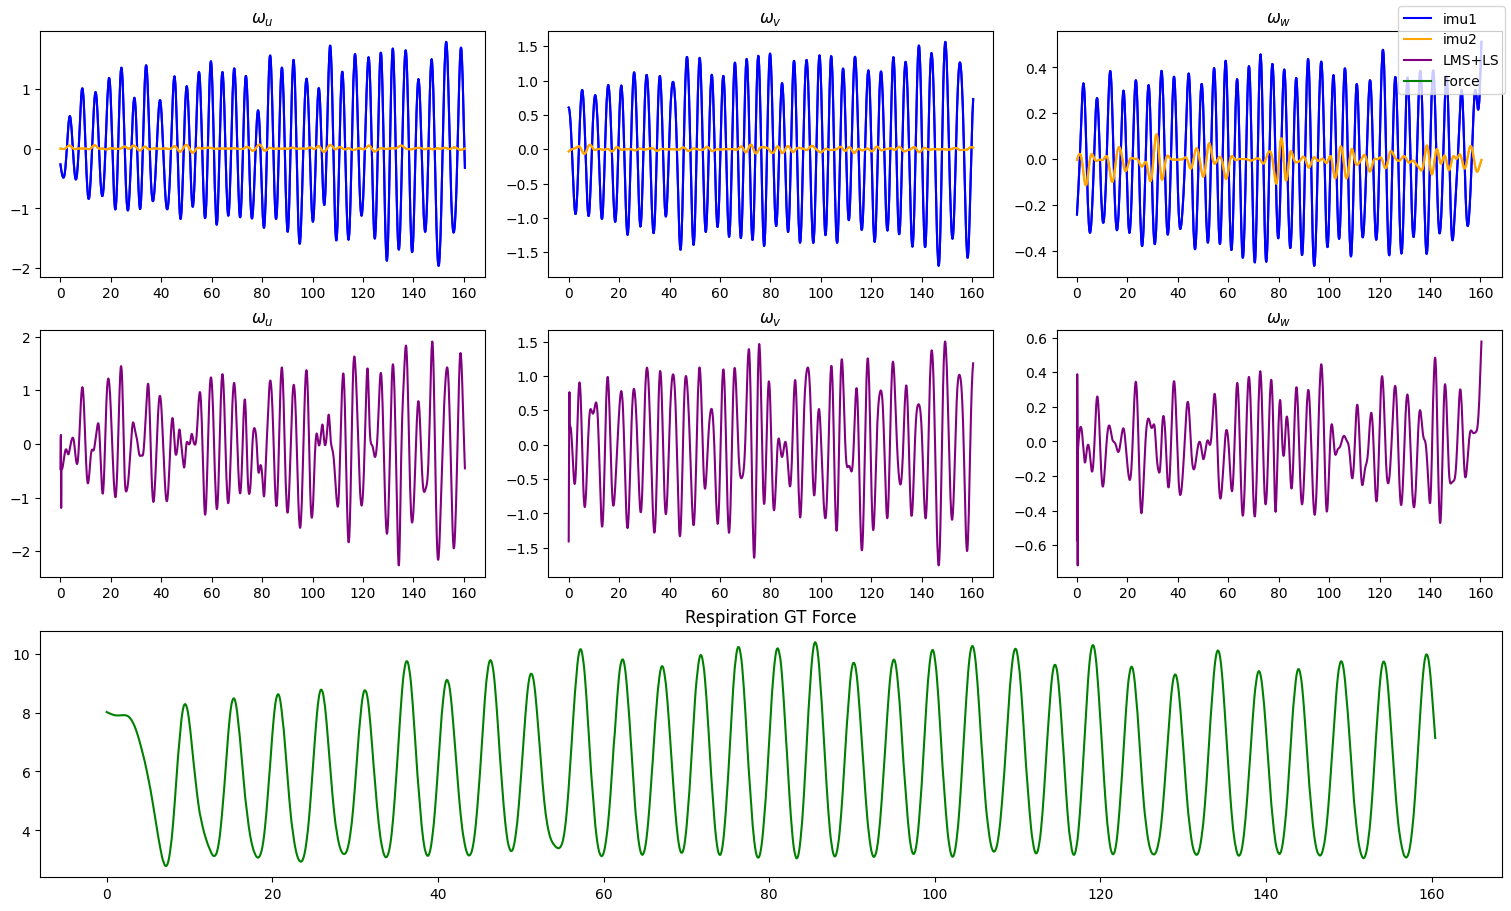

In [20]:
outputs_dict_LMSLS = {}
outputs_dict_LMSLS['method'] = 'LMS+LS'
coefficients_dict_LMSLS = {}
coefficients_dict_LMSLS['method'] = 'LMS+LS'
for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))

    # Least Square Once
    f.ls(x, d)
    LEARNING_RATE = np.max(f.coefficients) / (100) # / 100
    print(f'LEARNING_RATE:{LEARNING_RATE}')
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_LMSLS[col] = y
    coefficients_dict_LMSLS[col] = coefficients_history

draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMSLS], cols=cols)
# draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LMSLS)

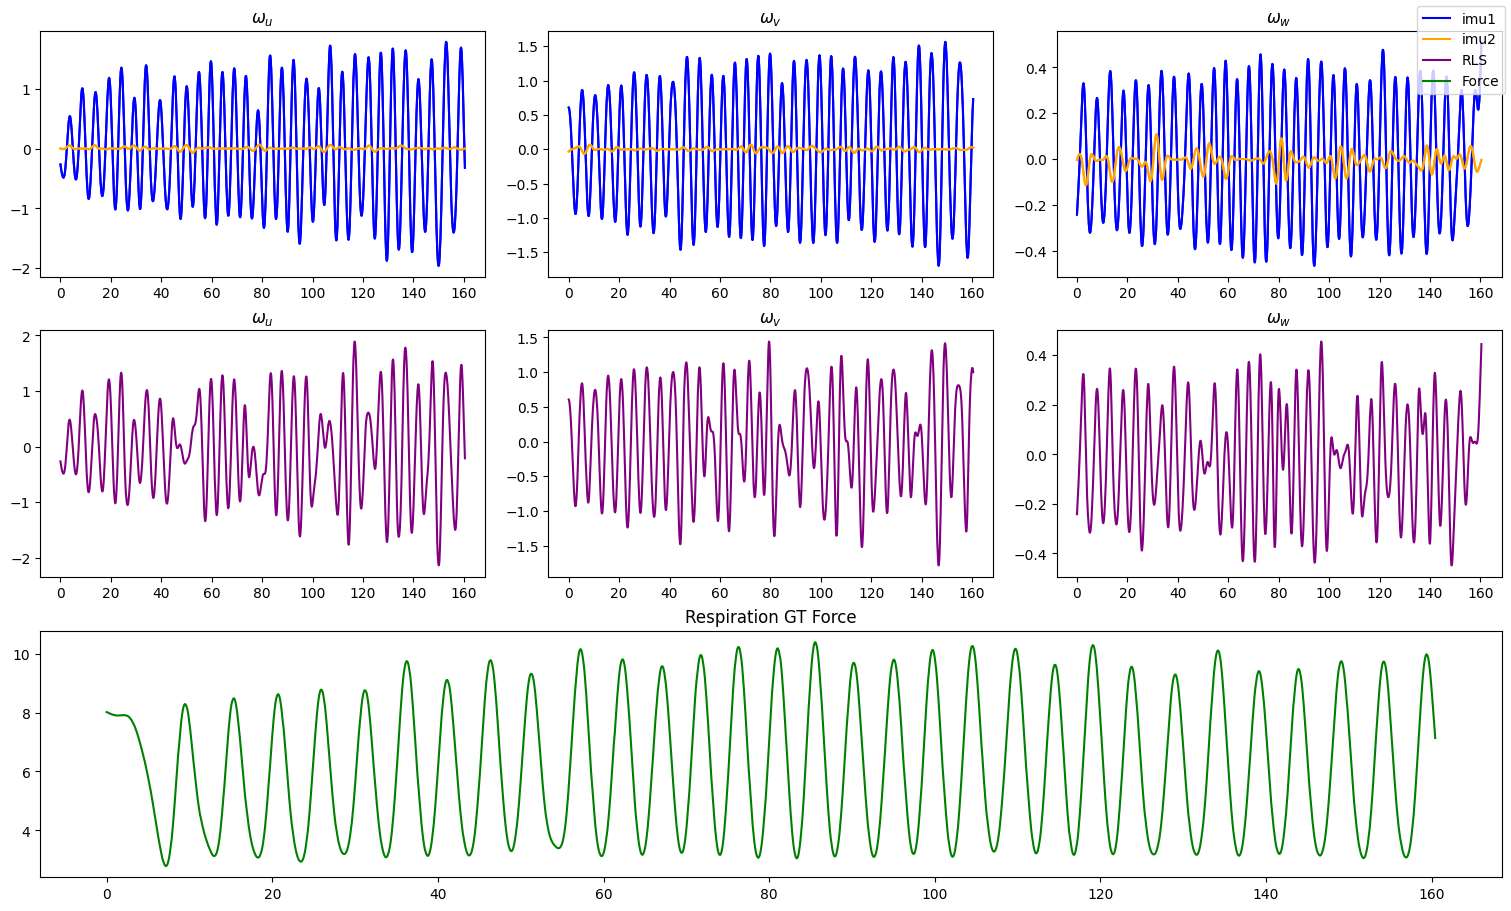

In [21]:
outputs_dict_RLS = {}
outputs_dict_RLS['method'] = 'RLS'
coefficients_dict_RLS = {}
coefficients_dict_RLS['method'] = 'RLS'

# RLS
delta = 1 # 1
lam_rls = 0.99 # 0.9995, 0.998

for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.rls(output_signal, delta=delta, lam=lam_rls)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_RLS[col] = y
    coefficients_dict_RLS[col] = coefficients_history

draw_anc_curve_multi(data_anc, outputs=[outputs_dict_RLS], cols=cols)
# draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_RLS)

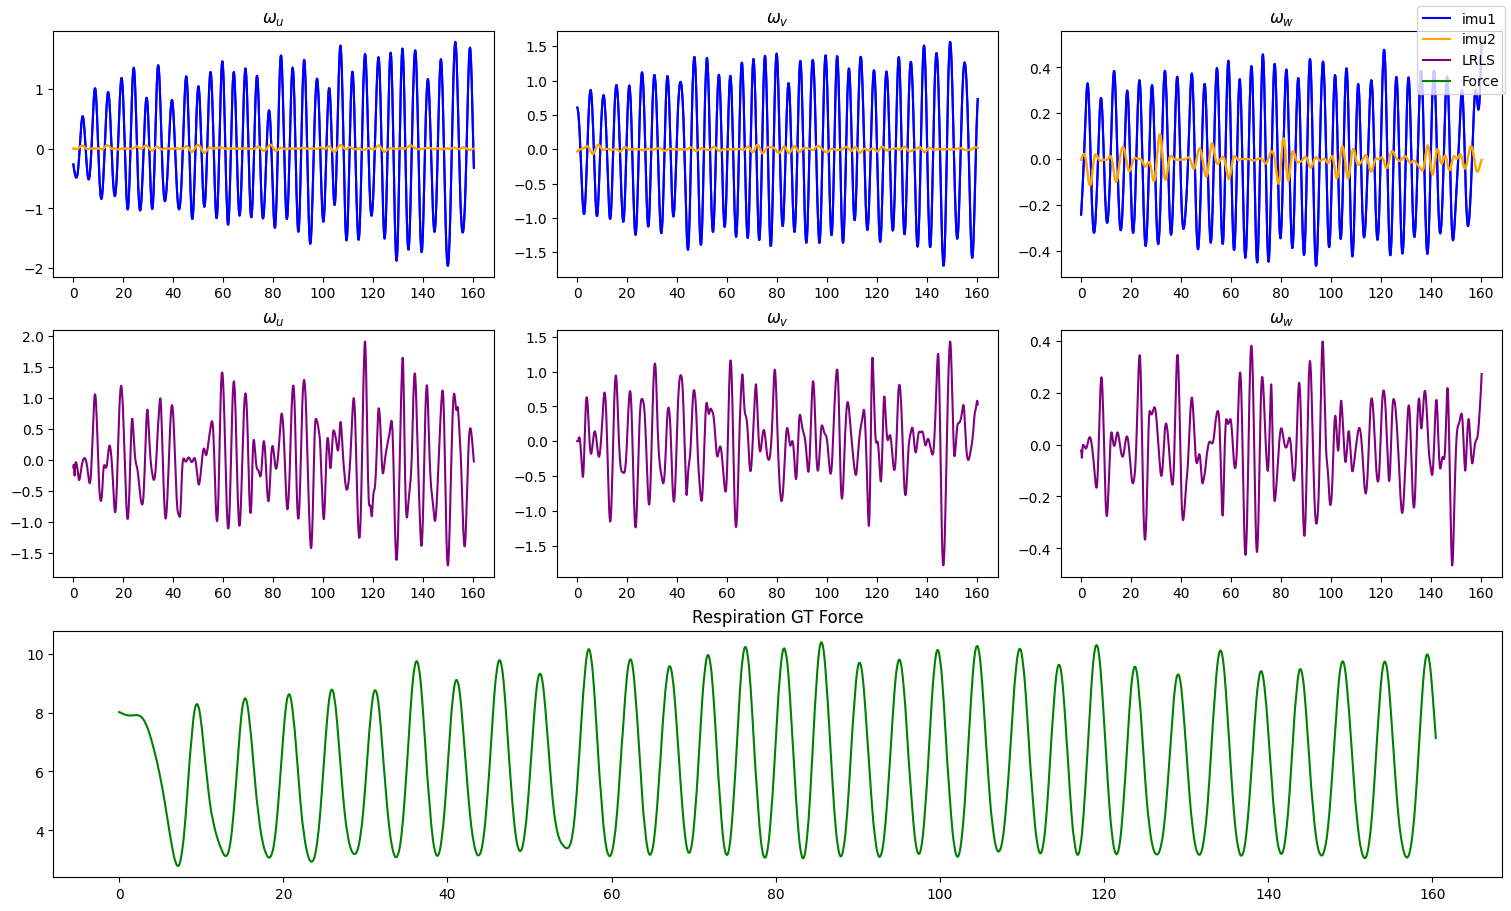

In [22]:
outputs_dict_LRLS = {}
outputs_dict_LRLS['method'] = 'LRLS'

# LRLS
epsilon = 1e-6
lam_lrls = 0.98 # 0.9995

for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        output_signal = f.lrls(x=ref_noise, d=d[i], N= len(d), lam=lam_lrls)
        y[i] = output_signal
    
    outputs_dict_LRLS[col] = y

draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LRLS], cols=cols)

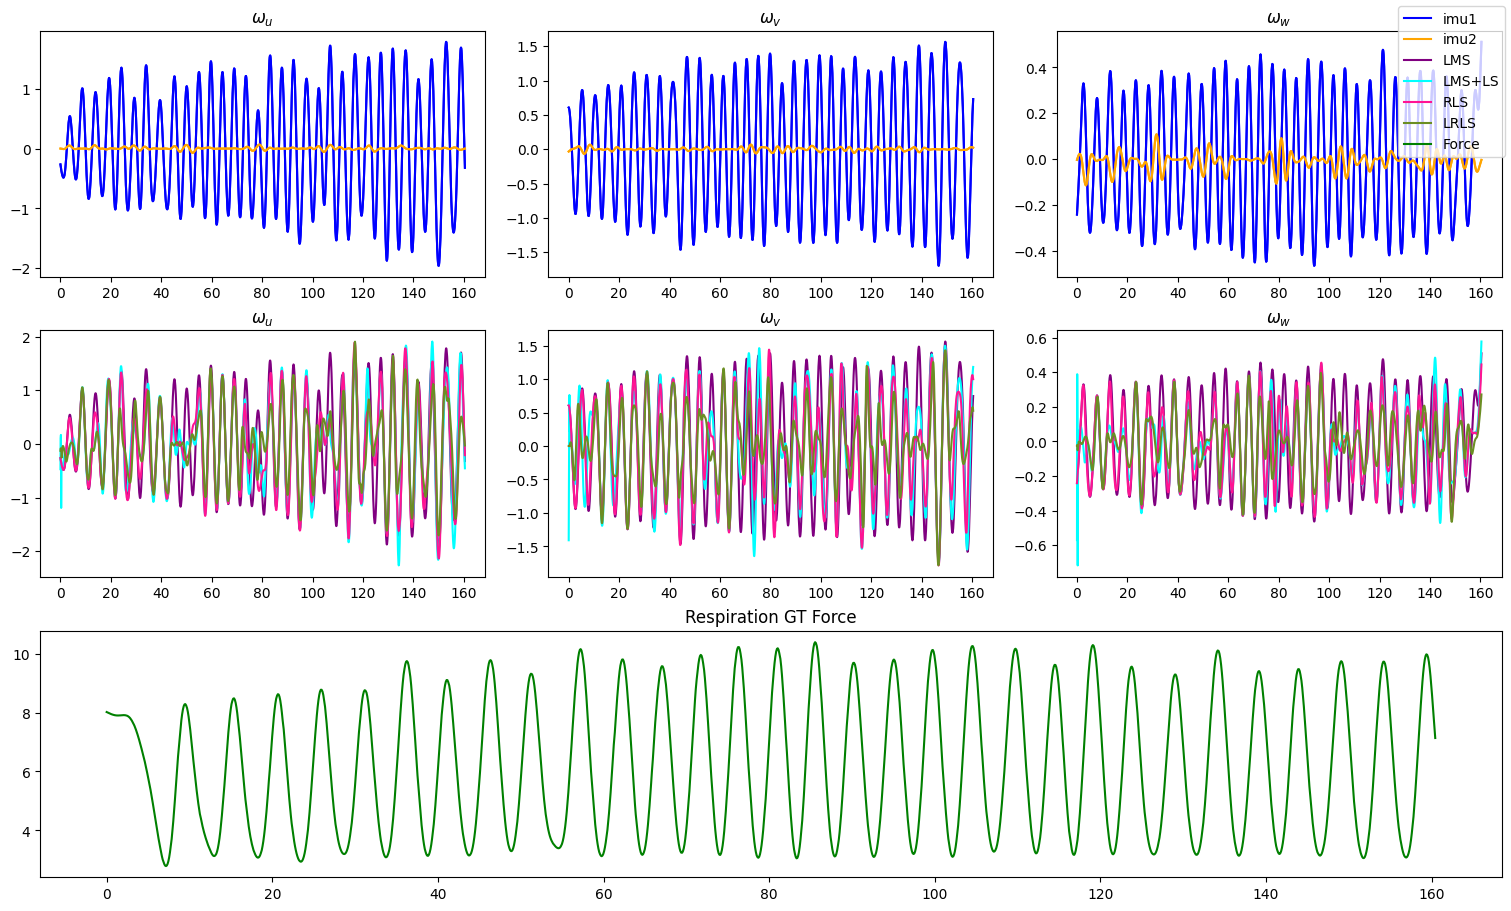

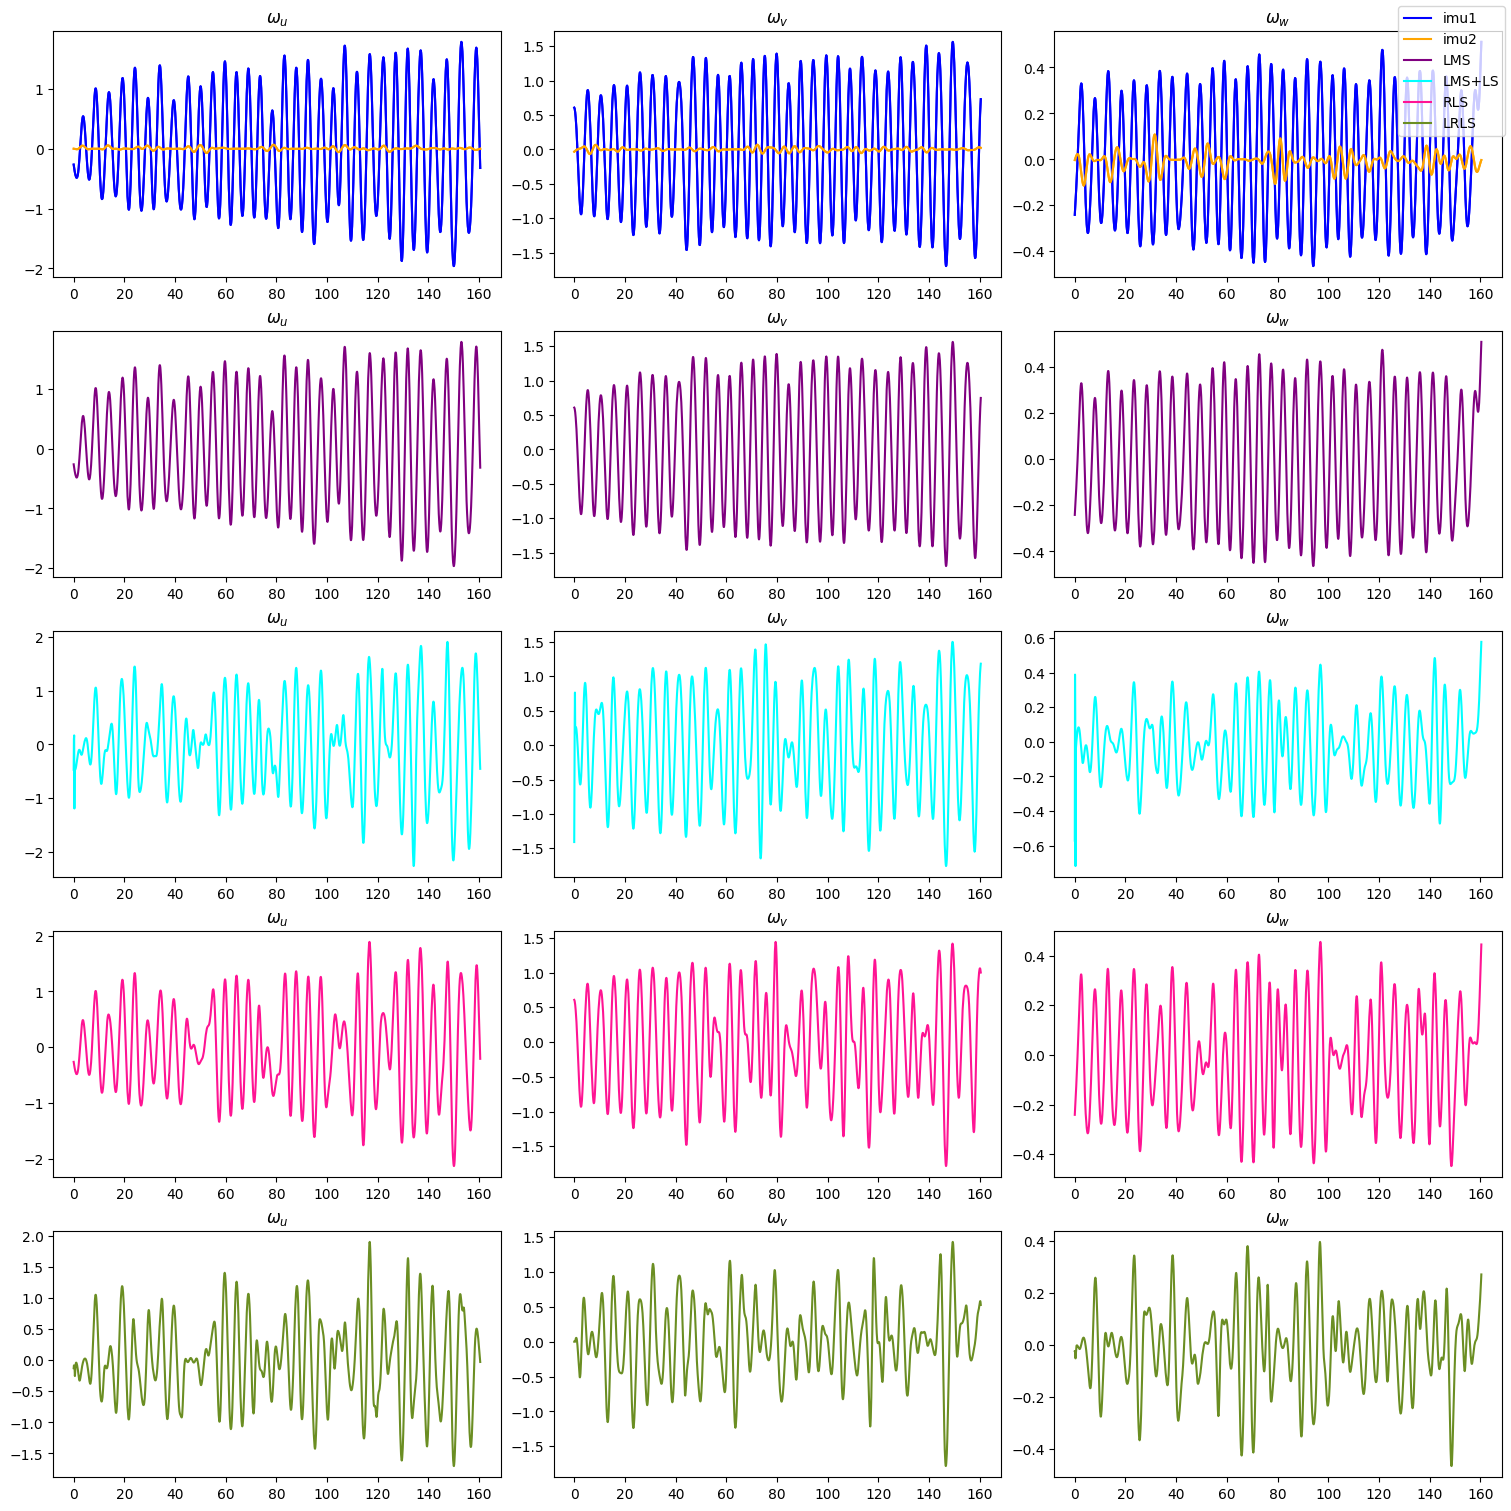

In [23]:
# Show all ANC results
draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], cols=cols)
draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], cols=cols, overlap=False, show_gt=False)

# Auto-Correlation

f_s :10, T:0.1, N:1638, n:100, t:163.8
window_num:77, overlap_size:80, window_size:100


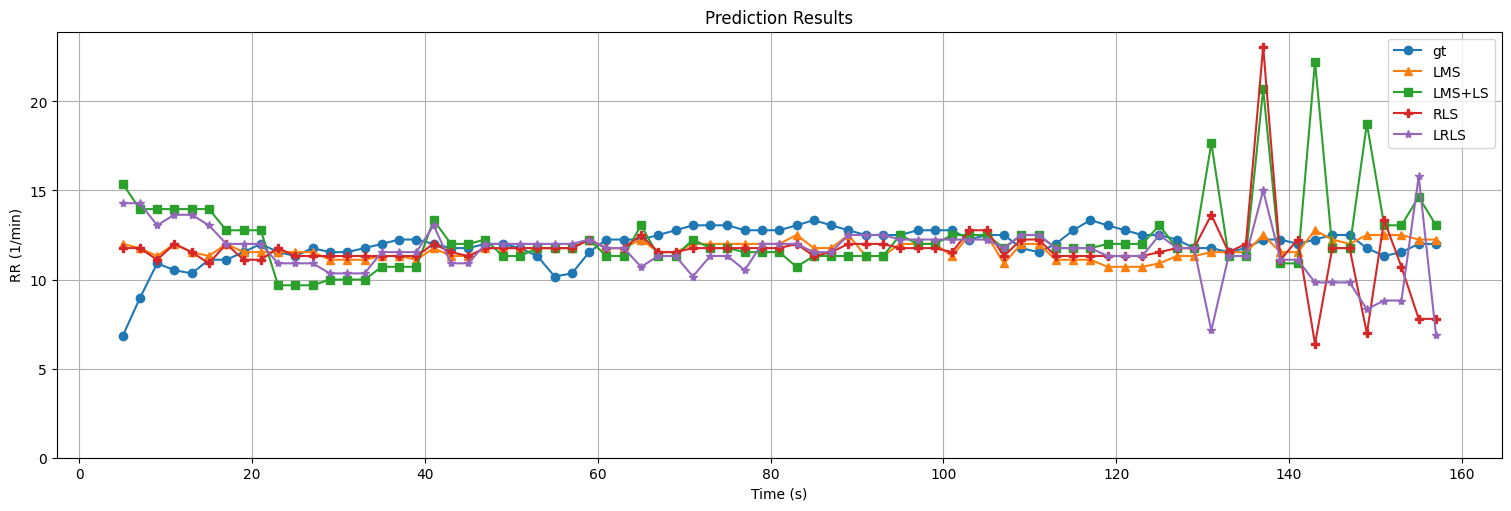

mae:{'LMS': 0.633916787534157, 'LMS+LS': 1.0311565758748833, 'RLS': 0.7951032848186469, 'LRLS': 1.066650400589875}


In [24]:
window = 10
overlap = window - 2
mae = auto_correlation(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], cols=cols,window=window, overlap=overlap, visualize=True)
print(f'mae:{mae}')